In [34]:
import os
import time
import numpy as np
import pandas as pd
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from hyperopt import hp
from hyperopt.pyll import scope

from src.Services.DataProcessService import DataProcessService
from src.Services.LoadDataFrameService import LoadDataFrameService
from src.Services.HyperparameterOptimizationService import HyperparameterOptimizationService
from src.Visualizations.LearningCurveVisualizer import LearningCurveVisualizer
from src.Visualizations.PredictionRangeAccuracyVisualizer import PredictionVisualizationService

In [ ]:
# MODEL_NAME = 'model_5_days_correct.keras'
MODEL_NAME = None
DATA_PATH = 'assets/crypto-data.csv'
SEQUENCE_LENGTH = 30
TEST_DAYS = 21
MODELS_DIR = os.path.join(os.curdir, "assets/models")
LOSS_METHOD = 'huber'

# Wczytanie danych

In [6]:
df = (LoadDataFrameService(DATA_PATH)).load_dataframe()

data_processor = DataProcessService(sequence_length=SEQUENCE_LENGTH, test_days=TEST_DAYS)

X_full, y_full = data_processor.create_sequences(df)
X_train, y_train, X_val, y_val, X_test, y_test = data_processor.split_data(X_full, y_full)

In [7]:
print(f"Test:       X={X_test.shape},  y={y_test.shape}")
print(f"Train:      X={X_train.shape}, y={y_train.shape}")
print(f"Validation: X={X_val.shape},   y={y_val.shape}")

Test:       X=(22, 30, 13),  y=(22, 3)
Train:      X=(2336, 30, 13), y=(2336, 3)
Validation: X=(259, 30, 13),   y=(259, 3)


# Model podstawowy


## Definiujemy model

In [ ]:
def build_basic_dense_model(hparams):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))

    for i in range(hparams['hidden_layers']):
        units = hparams[f'units_layer{i}']
        model.add(keras.layers.Dense(units))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(hparams['activation']))  

    model.add(keras.layers.Dense(3))

    optimizer = keras.optimizers.get(hparams['optimizer'])
    optimizer.learning_rate = hparams['lr']

    model.compile(optimizer=optimizer, loss=LOSS_METHOD)
    return model

## Przestrzeń hiperparametrów

In [9]:
space = {
    'epochs': 20,
    'hidden_layers': hp.randint('num_layers', 3, 5),
    'units_layer0': hp.randint('units_layer0', 64, 1024),
    'units_layer1': hp.randint('units_layer1', 64, 1024),
    'units_layer2': hp.randint('units_layer2', 64, 1024),
    'units_layer3': hp.randint('units_layer3', 64, 1024), 
    'units_layer4': hp.randint('units_layer4', 64, 1024), 
    'activation': hp.choice('activation', ['relu', 'elu']),
    'optimizer': hp.choice('optimizer', ['adam', 'nadam', 'rmsprop']),
    'lr': hp.loguniform('lr', np.log(1e-5), np.log(1e-2)),
    'batch_size': scope.int(hp.quniform('batch_size', 32, 256, 32)),
}

## Szukamy najlepszego

In [10]:
if MODEL_NAME is None:
    optimizer_service = HyperparameterOptimizationService(X_train, y_train, X_val, y_val, build_basic_dense_model)
    best_params, best_model, trials = optimizer_service.optimize(space, max_evals=10)

    print("Najlepsze hiperparametry:")
    print(best_params)

Epoch 1/20                                            

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/piotr/.pyenv/versions/3.12.9/envs/tensorflow/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

2025-04-11 18:44:01.095854: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


 1/37 ━━━━━━━━━━━━━━━━━━━━ 20s 571ms/step - loss: 25485.1719
15/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29752.0488   
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29965.5625
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 29923.1504 - val_loss: 30983.5195

Epoch 2/20                                            

 1/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 29481.8594
16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28579.9961 
31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28998.6309
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29153.1699 - val_loss: 30940.9512

Epoch 3/20                                            

 1/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 32173.2617
16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28931.1465 
31/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29158.8086
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29285.2402 - val_loss: 30896.5664

Epoch 4/20                                            

 1/37 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 27933.

## Budujemy wybrany już najlepszy model większą liczbą epok

In [11]:
model = None

if MODEL_NAME is None:
    model = best_model

    model.summary()
else:
    model = keras.models.load_model(f"{MODELS_DIR}/{MODEL_NAME}")

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 231)            │        90,321 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 231)            │           924 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 231)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 804)            │       186,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 804)            │         3,216 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 804)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 386)            │       310,730 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 386)            │         1,544 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 386)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 3)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,777,590 (6.78 MB)

 Trainable params: 591,582 (2.26 MB)

 Non-trainable params: 2,842 (11.10 KB)

 Optimizer params: 1,183,166 (4.51 MB)

In [12]:
model.layers

[<Flatten name=flatten_8, built=True>,
 <Dense name=dense_35, built=True>,
 <BatchNormalization name=batch_normalization_27, built=True>,
 <Activation name=activation_27, built=True>,
 <Dense name=dense_36, built=True>,
 <BatchNormalization name=batch_normalization_28, built=True>,
 <Activation name=activation_28, built=True>,
 <Dense name=dense_37, built=True>,
 <BatchNormalization name=batch_normalization_29, built=True>,
 <Activation name=activation_29, built=True>,
 <Dense name=dense_38, built=True>]

In [ ]:
if MODEL_NAME is None:
    optimizer_name = best_params['optimizer']
    optimizer_class = getattr(tf.keras.optimizers, optimizer_name.capitalize())
    optimizer = optimizer_class(learning_rate=best_params['lr'])

    model.compile(optimizer=optimizer, loss=LOSS_METHOD)

In [26]:
model_id = time.strftime("model_%Y_%m_%d-%H_%M_%S")
model_path = f"{MODELS_DIR}/{model_id}.keras"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path, save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=300, restore_best_weights=True)

class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nwalidacja/uczenie: {:.2f}".format(logs["val_loss"] / logs["loss"]))

print_val_train_ratio_cb = PrintValTrainRatioCallback()

In [38]:
history = None
if MODEL_NAME is None:
    history = model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[
            checkpoint_cb,
            early_stopping_cb,
            print_val_train_ratio_cb
        ]
    )

Epoch 1/50
72/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 120153080.0000
walidacja/uczenie: 1.10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 120043392.0000 - val_loss: 127656896.0000
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 107329856.0000
walidacja/uczenie: 7.34
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 107466232.0000 - val_loss: 861773888.0000
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129366848.0000
walidacja/uczenie: 2.43
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 129257800.0000 - val_loss: 294192192.0000
Epoch 4/50
71/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 107503928.0000
walidacja/uczenie: 1.89
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 107492520.0000 - val_loss: 203037568.0000
Epoch 5/50
71/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 123988096.0000
walidacja/uczenie: 1.10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 124194728.0000 - val_loss: 141931856.0000
Epoch 6/50
68/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110394120.00

KeyboardInterrupt: 

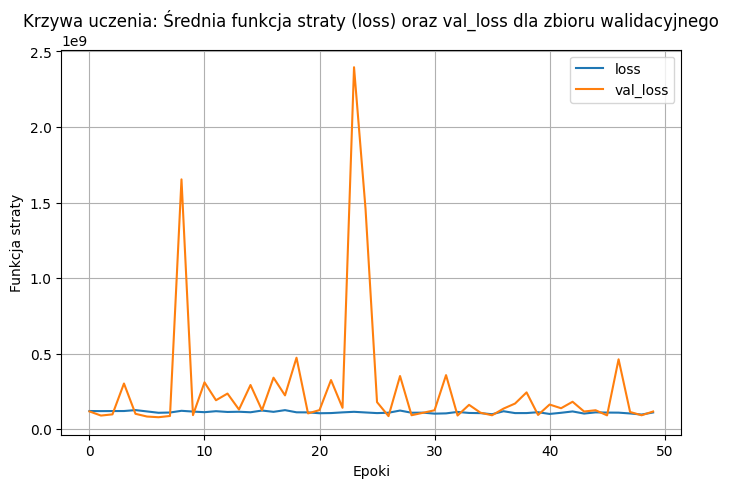

In [36]:
if history is not None:
    plot = LearningCurveVisualizer(history)
    plot.visualize()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


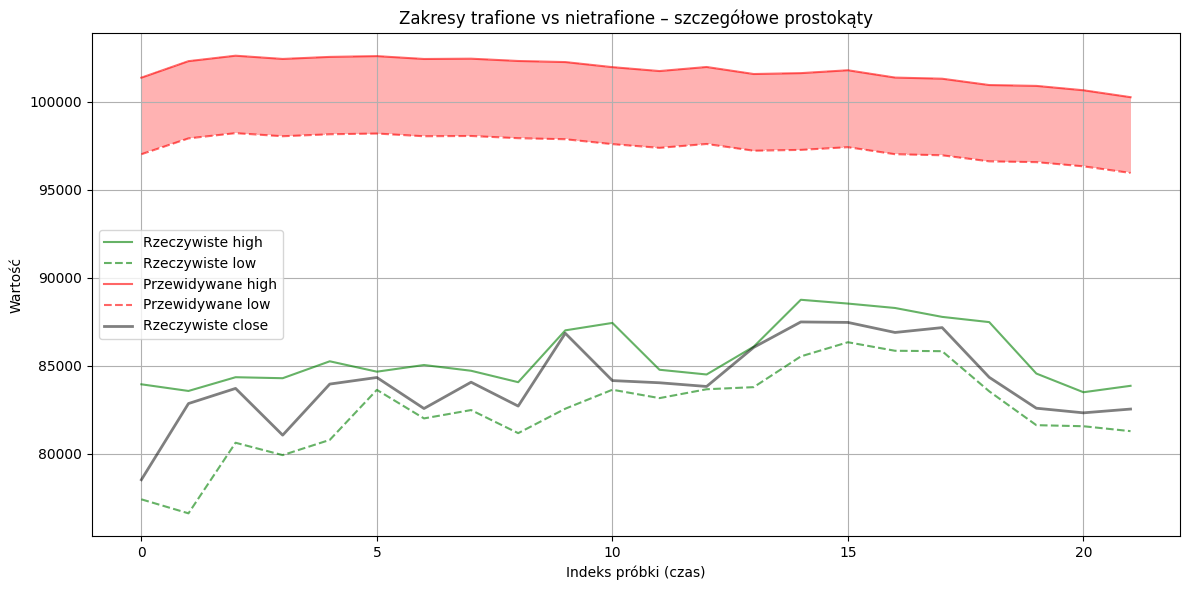

In [37]:
predictions = model.predict(X_test)
plot = PredictionVisualizationService(y_test, predictions)
plot.visualize()